# Identify High Latitude Dust in given MODIS imagery

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/15F-jiZGtK107HAAIXr1qdmVnp131L5wt">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

## Install Geopandas and TensorFlow 1.15

In [90]:
!pip install geopandas
!pip install tensorflow==1.15.0

## Imports

Imports for all the steps and processes are done in the following cell.

In [ ]:
import re
import os
import glob
import zipfile
import functools
import requests
import urllib
import xml.etree.ElementTree as ET
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from PIL import Image

import shapely
import geopandas as gp

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K  

## Data Fetching

At first, all the shapefiles are downloaded and saved in the folder `Shapefiles` in proper hierarchal structure. Each shapefile has a different folder.

The XML file from the AWS URL, https://s3.amazonaws.com/hld-datashare, is created and saved as hld.xml. Then the following code is run to download all the shapefiles in the folder, `Shapefiles`.

In [ ]:
# define BASE_DIR
BASE_DIR = "My Drive/NASA-IMPACT/MODIS_HLD/"

In [ ]:
# get root for the xml file
root = ET.parse(BASE_DIR + 'aws.xml').getroot()

# iterate over all the URLs and save in proper hierarchy
for child in root.getchildren():
    if child.getchildren():
        for grandchild in child.getchildren():
            if re.search(r'(prj|dbf|shp|shx)', grandchild.text):
                
                filename = grandchild.text.strip('\n').split('/')
                
                if not os.path.isdir(BASE_DIR + 'Shapefiles/' + filename[0]):
                    os.mkdir(BASE_DIR + 'Shapefiles/' + filename[0])
                    
                response = requests.get('https://s3.amazonaws.com/hld-datashare/' + filename[0] + '/' + filename[1])
                
                with open(BASE_DIR + 'Shapefiles/' + filename[0] + '/' + filename[1], 'wb') as f:
                    f.write(response.content)

Now, we will cut the polygon portion defined in the shapefiles from the API called image. That portion acts as the mask and the masked images are formed using the portion. For creating the masked images, bounding box dimension of the shapefile is used. Caching is done for possible connection errors. Also, the fails API calls (because of file not present error, corrupt file error, etc) are ignored.

In [ ]:
cache = set()

In [ ]:
# URL to call the API and constant, KM_PER_DEG_AT_EQ
URL = "https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?SERVICE=WMS&REQUEST=GetMap&layers=MODIS_Aqua_CorrectedReflectance_TrueColor&version=1.3.0&crs=EPSG:4326&transparent=false&width={}&height={}&bbox={}&format=image/tiff&time={}"
KM_PER_DEG_AT_EQ = 111.


def calculate_width_height(extent, resolution):
    """
    extent: [lower_latitude, left_longitude, higher_latitude, right_longitude], EG: [51.46162974683544,-22.94768591772153,53.03698575949367,-20.952234968354432]
    resolution: represents the pixel resolution, i.e. km/pixel. Should be a value from this list: [0.03, 0.06, 0.125, 0.25, 0.5, 1, 5, 10]
    """
    lats = extent[::2]
    lons = extent[1::2]
    km_per_deg_at_lat = KM_PER_DEG_AT_EQ * np.cos(np.pi * np.mean(lats) / 180.)
    width = int((lons[1] - lons[0]) * km_per_deg_at_lat / resolution)
    height = int((lats[1] - lats[0]) * KM_PER_DEG_AT_EQ / resolution)
    print(width, height)
    return (width, height)


def modis_url(time, extent, resolution):
    """
    time: utc time in iso format EG: 2020-02-19T00:00:00Z
    extent: [lower_latitude, left_longitude, higher_latitude, right_longitude], EG: [51.46162974683544,-22.94768591772153,53.03698575949367,-20.952234968354432]
    resolution: represents the pixel resolution, i.e. km/pixel. Should be a value from this list: [0.03, 0.06, 0.125, 0.25, 0.5, 1, 5, 10]
    """
    width, height = calculate_width_height(extent, resolution)
    extent = ','.join(map(lambda x: str(x), extent))
    return (width, height, URL.format(width, height, extent, time))


# creates images and masks using the downloaded shapefiles and given API
for shapefile in os.listdir(BASE_DIR + 'Shapefiles'):
    
    # if the data creation is already done for the shapefile, skip
    if shapefile in cache: continue
    
    # condition employed to ignore other files/folders (like .ipynb_checkpoints)
    if 'high-latitude-dust' in shapefile:
        
        assert (gp.read_file(BASE_DIR + 'Shapefiles/{}'.format(shapefile)).index == pd.Index([0]))
        assert (gp.read_file(BASE_DIR + 'Shapefiles/{}'.format(shapefile)).columns == pd.Index(['FID', 'geometry'])).all()
        
        shape = gp.read_file(BASE_DIR + 'Shapefiles/{}'.format(shapefile)).loc[0, 'geometry']
        
        # get bounding coordinates of the shapefile
        minlong, minlat, maxlong, maxlat = shape.bounds
        
        # use the above function to get width, height and API URL
        width, height, url = modis_url(file_path.split('_')[1] + 'T00:00:00Z', [minlat, minlong, maxlat, maxlong], 0.5)
        
        # call URL and get the image
        response = requests.get(url)
        img = BytesIO(response.content)
        
        # in case failure occurs in getting the image, ignore; it was found out that there are 8 failed cases
        try:
            W, H = Image.open(img).size
        except:
            continue
            
        # creation of mask images
        # it is to be noted that approximate method is used here for mask creation; happy to use more accurate method if found one
        labelled_image = [[0 for _ in range(W)] for _ in range(H)]
        x1, y1, x2, y2 = shape.bounds
        for i in range(len(labelled_image)):
            for j in range(len(labelled_image[0])):
                h1 = y2 - i * (y2 - y1) / H
                w1 = x1 + j * (x2 - x1) / W
                if shape.contains(shapely.geometry.Point(w1, h1)):
                    labelled_image[i][j] = 1
                    
        # save images and masks, and cache the shapefile
        Image.open(img).save(BASE_DIR + 'Data/Images/' + file_path + '.jpg')
        image = Image.new('1', (W, H))
        image.putdata([j for i in labelled_image for j in i])
        image.save(BASE_DIR + 'Data/Masks/' + file_path + '.jpg')
        cache.add(file_path)

## Data Preprocessing

### Get the list of images and labels / masks

In [ ]:
images = [BASE_DIR + 'Data/Images/' + i for i in os.listdir(BASE_DIR + 'Data/Images') if not os.path.isdir(BASE_DIR + 'Data/Images/' + i)]
labels = [BASE_DIR + 'Data/Masks/' + i for i in os.listdir(BASE_DIR + 'Data/Masks/') if not os.path.isdir(BASE_DIR + 'Data/Masks/' + i)]

### Sort the images and labels so that we can do easy splitting into training and validation sets

In [ ]:
images = sorted(images)
labels = sorted(labels)

In [97]:
len(images), len(labels)

(206, 206)

### Split the images and labels as training and validation sets

In [ ]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(images, labels, test_size=0.3, random_state=42)

In [99]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 144
Number of validation examples: 62


### See the filepaths for input and output data

In [100]:
x_train_filenames[:10]

['My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2017-11-14_202.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2009-06-21_54.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2017-11-13_36.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2005-01-11_258.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2003-03-13_264.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2005-01-17_257.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2012-10-27_226.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2006-10-28_252.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2009-07-05_100.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Images/high-latitude-dust_2009-12-25_60.jpg']

In [101]:
y_train_filenames[:10]

['My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2017-11-14_202.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2009-06-21_54.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2017-11-13_36.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2005-01-11_258.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2003-03-13_264.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2005-01-17_257.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2012-10-27_226.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2006-10-28_252.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2009-07-05_100.jpg',
 'My Drive/NASA-IMPACT/MODIS_HLD/Data/Masks/high-latitude-dust_2009-12-25_60.jpg']

### View five random images and corresponding masks

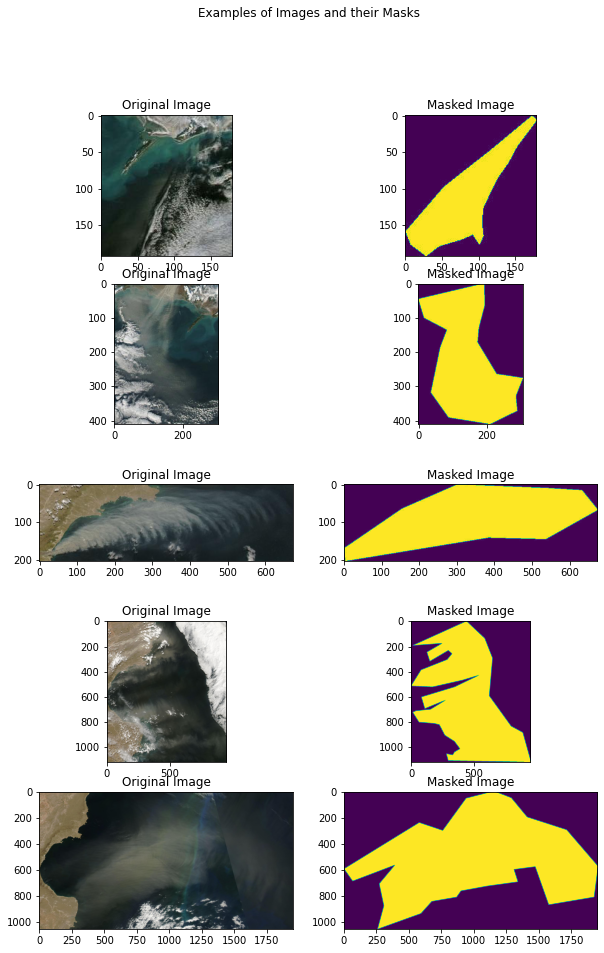

In [ ]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]
    
    plt.subplot(display_num, 2, i + 1)
    plt.imshow(mpimg.imread(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)
    
    plt.subplot(display_num, 2, i + 2)
    plt.imshow(np.array(example_labels))
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

### Set some of the variables for input dimension, epoch number, and batch size

In [ ]:
img_shape = (256, 256, 3)
batch_size = 15
epochs = 10

### Preprocessing, data augmentation by shifting and flipping

In [ ]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair  
    img_str = tf.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)

    label_img_str = tf.read_file(label_path)
    label_img = tf.image.decode_jpeg(label_img_str, channels=1)

    return img, label_img

In [ ]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        # Translate both 
        output_img = tfcontrib.image.translate(output_img, [width_shift_range, height_shift_range])
        label_img = tfcontrib.image.translate(label_img, [width_shift_range, height_shift_range])
    return output_img, label_img

In [ ]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5), lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)), lambda: (tr_img, label_img))
    return tr_img, label_img

In [ ]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize_images(label_img, resize)
        img = tf.image.resize_images(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.to_float(label_img) * scale
    img = tf.to_float(img) * scale 
    return img, label_img

In [ ]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)


    # It's necessary to repeat our data for all epochs 
    dataset = dataset.repeat().batch(batch_size)
    return dataset

### Data normalization by dividing by 255 and creation of data generators

In [ ]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [ ]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [ ]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


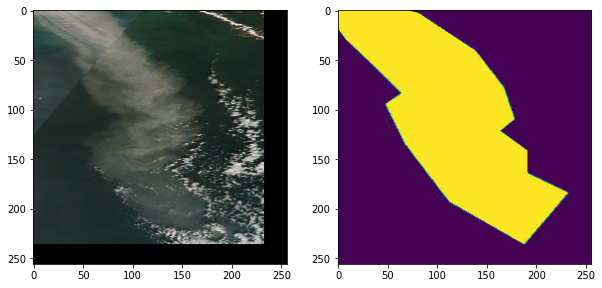

In [ ]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
    batch_of_imgs, label = sess.run(next_element)

    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(label[0].reshape(256, 256))
    plt.show()

## Applying algorithms

We use U-Net model to perform the image segmentation task as it is especially good with segmentation tasks. Unlike the original model, we will add batch normalization to each of our blocks.

### Blocks definition

The Keras functional API is used here. It is a powerful API that allows to manipulate tensors and build complex graphs with intertwined datastreams easily. In addition, it makes layers and models both callable on tensors.

We will build these helper functions that will allow us to emsemble our model block operations easily and simply.

In [ ]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

### Model formation

In [ ]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Define your model
Using functional API, you must define your model by specifying the inputs and outputs associated with the model. 

In [ ]:
model = models.Model(inputs=[inputs], outputs=[outputs])

### Definition of losses

It is easy to define loss and metric with Keras. We can define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

Dice loss measures overlap between predicted mask and true mask. It was introduced in this [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf).

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Here, we will use a specialized loss function that combines both binary cross entropy and our dice loss.

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

### Compile the model

In [ ]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss, 'accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        


### Train the model

We use Model callback, ModelCheckpoint that will save the model to disk after each epoch. We also configure it such that it only saves our highest performing model. 

In [ ]:
save_model_path = BASE_DIR + 'weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [ ]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Train on 10 steps, validate on 5 steps
Epoch 1/10
 9/10 [==========================>...] - ETA: 43s - loss: 0.8683 - dice_loss: 0.3331 - acc: 0.6840 
Epoch 00001: val_dice_loss improved from inf to 0.92722, saving model to My Drive/NASA-IMPACT/GRA-Assignment/weights_workshop.hdf5
10/10 [==============================] - 495s 49s/step - loss: 0.8745 - dice_loss: 0.3326 - acc: 0.6795 - val_loss: 3.6985 - val_dice_loss: 0.9272 - val_acc: 0.4341
Epoch 2/10
 9/10 [==========================>...] - ETA: 42s - loss: 0.8340 - dice_loss: 0.3262 - acc: 0.6955 
Epoch 00002: val_dice_loss improved from 0.92722 to 0.50933, saving model to My Drive/NASA-IMPACT/GRA-Assignment/weights_workshop.hdf5
10/10 [==============================] - 482s 48s/step - loss: 0.8336 - dice_loss: 0.3242 - acc: 0.6969 - val_loss: 1.2858 - val_dice_loss: 0.5093 - val_acc: 0.2965
Epoch 3/10
 9/10 [==========================>...] - ETA: 42s - loss: 0.8291 - dice_loss: 0.3190 - acc: 0.7043 
Epoch 00003: val_dice_loss did n

## Evaluating the model

### Visualize training process

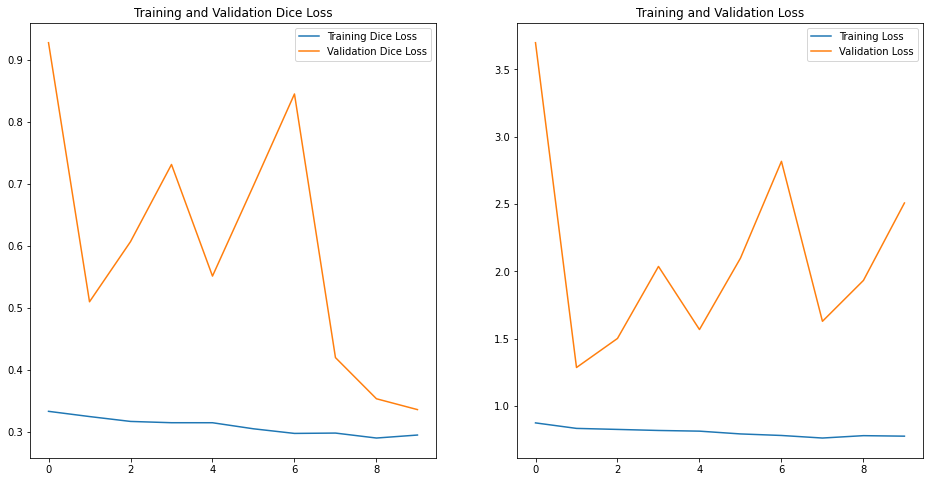

In [ ]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## Visualizing the results

### Visualize actual performance

In [ ]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(BASE_DIR + "weights.hdf5", custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


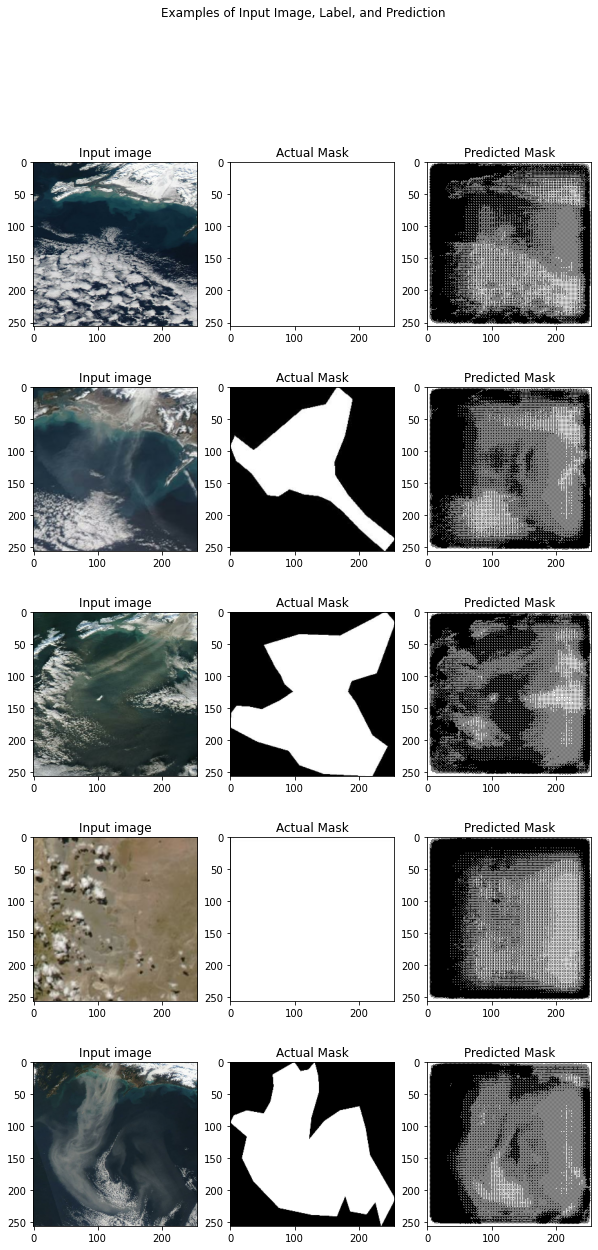

In [ ]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)

    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[0].reshape(256, 256), cmap='gray')
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_label[0].reshape(256, 256) < (predicted_label[0].mean()), cmap='gray')
    plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

Our model does not perform as good as we would have liked. Some of the possible ways to improve the model are given below.

## Possible ways to improve the model

1. We have used simple scaling algorithm to create the masked images from the shapefiles and TIFF images. We can use other more accurate techniques (possibly using the knowledge of different projections for different locations) to extract the portion of dust.
2. We have used one channel for the masked image. If we use three channels for the masked image, we might be able to see the dust portion in predicted mask by some color more clearly. 
3. The downloaded training images have varying aspect ratio. If we could download the images such that aspect ratio remains same across all the images, we could reduce the noise produced by reshaping.
4. Instead of putting data in Google Drive, we could put data in more efficient format (like tf.record) and load from there. That makes the training faster, so allowing us to do more hyperparamter tuning.
5. We could try other image segmentation models like FCN, SCNN, etc and see how they perform.